<a href="https://colab.research.google.com/github/subhani92/Deep_learning/blob/master/lemon_classification_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#public score 0.95

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras
import albumentations as A
from sklearn import model_selection, preprocessing 
import cv2
import tensorflow as tf
import numpy as np 
from matplotlib import pyplot as plt
from PIL import Image

In [ ]:
test_dir = "/content/drive/test_images" # add path of your data
train_dir = "/content/drive/train_images"

In [ ]:
df = pd.read_csv("/content/drive/train_images.csv")

In [ ]:
df.head(5)

,id,class_num
0,train_0000.jpg,0
1,train_0001.jpg,0
2,train_0002.jpg,0
3,train_0003.jpg,0
4,train_0004.jpg,0


In [ ]:
num_classes = len(df["class_num"].unique())

In [ ]:
images, labels = df['id'].values, df['class_num'].values


In [ ]:
test_images = [name for name in sorted(os.listdir(test_dir))]

In [ ]:
df.class_num = df.class_num.astype("str")
batch_size=16
input_size = (300, 300)


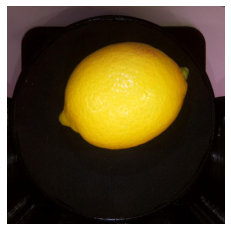

In [ ]:
im = Image.open(os.path.join(train_dir, df["id"][0]))
plt.imshow(im)
plt.axis("off")
plt.show()

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split = 0.1, #10 for validation 
    rotation_range=360,
    #zca_whitening=True,
    #zca_epsilon=1e-06,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=[0.5,1.0],
    #channel_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None,
    preprocessing_function=None,
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_dir,
    x_col="id",
    y_col="class_num",
    batch_size=batch_size,
    target_size=input_size,
    class_mode="sparse", 
    subset = "training"
)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.1)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_dir,
    x_col="id",
    y_col="class_num",
    batch_size=batch_size,
    target_size=input_size ,
    class_mode="sparse", 
    subset="validation")

Found 992 validated image filenames belonging to 4 classes.
Found 110 validated image filenames belonging to 4 classes.


**Let's see some data**

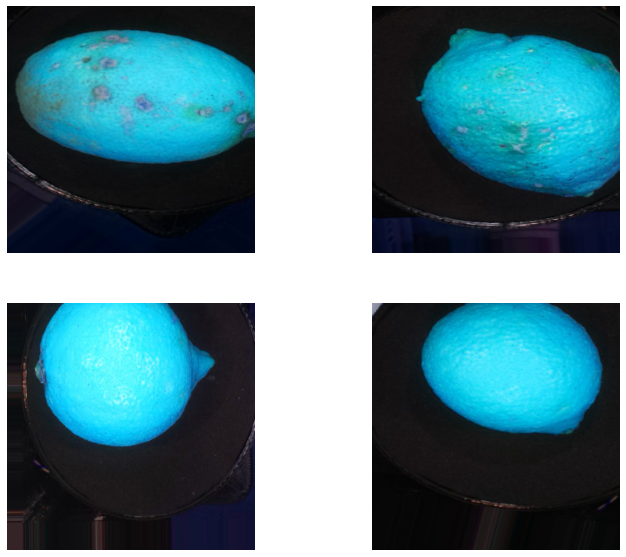

In [ ]:
plt.figure(figsize=(12,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    batch = train_generator.next()
    image = batch[0].astype('uint8')
    plt.imshow(np.array(image[0,:,:,::-1]))
    plt.axis("off")
# show the figure
plt.show()            
            

**Train + inference**

In [ ]:
from tensorflow.keras.applications import EfficientNetB0 #
from keras import Model
from keras import optimizers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D,  GlobalAveragePooling2D, Activation , Dense


#model_weight_dir = ""
model = Sequential()
model.add( tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet", input_shape=(300, 300, 3)))
model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes, activation="softmax"))
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 6148      
Total params: 10,789,683
Trainable params: 10,702,380
Non-trainable params: 87,303
_________________________________________________________________


In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
             metrics=['accuracy'])

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model_efficnetb3.h5',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

hist  = model.fit_generator(
    train_generator,
    validation_data = valid_generator,
    #
    steps_per_epoch = len(df)*0.9//batch_size,
    validation_steps = len(df)*0.1//batch_size, 
    epochs = 20,
    callbacks = [model_checkpoint ,early_stopping]
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
61/61 [==============================] - 286s 4s/step - loss: 0.9932 - accuracy: 0.6041 - val_loss: 1.1713 - val_accuracy: 0.4062
Epoch 2/20
61/61 [==============================] - 40s 650ms/step - loss: 0.3690 - accuracy: 0.8738 - val_loss: 0.6288 - val_accuracy: 0.7396
Epoch 3/20
61/61 [==============================] - 40s 649ms/step - loss: 0.2699 - accuracy: 0.9189 - val_loss: 0.3609 - val_accuracy: 0.9167
Epoch 4/20
61/61 [==============================] - 40s 657ms/step - loss: 0.2088 - accuracy: 0.9185 - val_loss: 0.1310 - val_accuracy: 0.9583
Epoch 5/20
61/61 [==============================] - 40s 646ms/step - loss: 0.1565 - accuracy: 0.9413 - val_loss: 0.1568 - val_accuracy: 0.9479
Epoch 6/20
61/61 [==============================] - 39s 642ms/step - loss: 0.1506 - accuracy: 0.9441 - val_loss: 0.1763 - val_accuracy: 0.9167
Epoch 7/20
61/61 [==============================] - 39s 641ms/step - loss: 0.1408 - accuracy: 0.9410 - val_loss: 0.0787 - val_accuracy: 0.9688
E

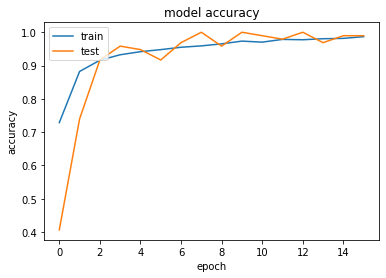

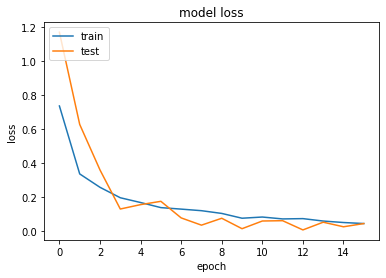

In [ ]:
# accuracy 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
test_df = pd.read_csv("/content/drive/test_images.csv")

In [ ]:
predictions = []
for  image_id in test_df.id:
    img = Image.open(os.path.join(test_dir+"/"+image_id))
    img = img.resize((300,300))
    img = np.expand_dims(img, axis=0)
    predictions.append(np.argmax(model.predict(img)))

sample_df["label"] = predictions
#sample_df


In [ ]:
sample_df.to_csv("submission.csv",  header=False, index=False)